In [1]:
# Data Wrangling & Plotting
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
sns.set_style('whitegrid')
sns.set_palette("deep")

#ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [2]:
gender_submission = pd.read_csv("gender_submission.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

df = pd.concat([train,test], axis=0, sort=False)


# Functions

In [3]:
def display_num_nulls(df):
    '''
    Displays number of missing values in a dataframe
    
    Parameters:
    df: Dataframe
    '''
    display(pd.concat([df.isnull().sum(), df.isnull().mean()], axis=1).rename(columns={0:'sum', 1:'avg'}))

def title_extractor(df, names_col = 'Name'):
    ''' Extracts Titles from a series of names
    Parameters: 
    df: dataframe to extract from
    names_col: dolumn of df containing names
    
    Returns: series of extracted titles
    
    '''
    return df['Name'].str.extract(r'(,\s[A-z]+\.)')[0].str.strip(' ,')

def impute_category_mean(df, missing_col, by_cat_col):
    '''
    Imputes missing values using the mean defined by a particular category
    
    Parameters:
    df: dataframe
    missing_col: column to impute
    by_cat_col: column containing categories to compute mean
    
    Returns: series with imputed values
    '''
    return df.groupby(by_cat_col)[missing_col].transform(lambda x: x.fillna(x.mean()))
     

# EDA

In [4]:
display_num_nulls(train)

,sum,avg
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,0.198653
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


In [5]:
display_num_nulls(test)

,sum,avg
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,86,0.205742
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,1,0.002392
Cabin,327,0.782297


In [6]:
display_num_nulls(df)

,sum,avg
PassengerId,0,0.000000
Survived,418,0.319328
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,263,0.200917
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,1,0.000764


In [7]:
train.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

Text(0.5, 1.0, 'Count of Survivors and Goners')

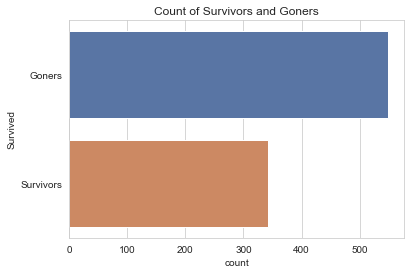

In [8]:
sns.countplot(y=train['Survived']).set_yticklabels(['Goners', 'Survivors'])
plt.title('Count of Survivors and Goners')

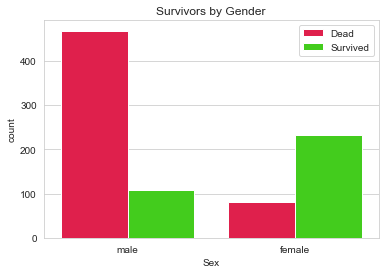

In [9]:
sns.countplot('Sex', hue = 'Survived', data=train, palette='prism_r')
plt.title("Survivors by Gender")
plt.legend(['Dead','Survived'])

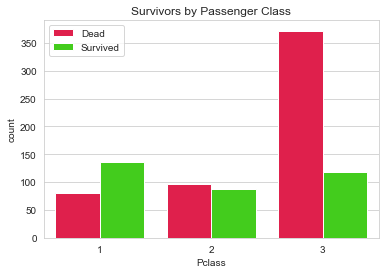

In [10]:
sns.countplot(hue='Survived',x='Pclass',data=train,palette = 'prism_r')
plt.title("Survivors by Passenger Class")
plt.legend(['Dead','Survived'])


[Text(0.5, 0, 'Age')]

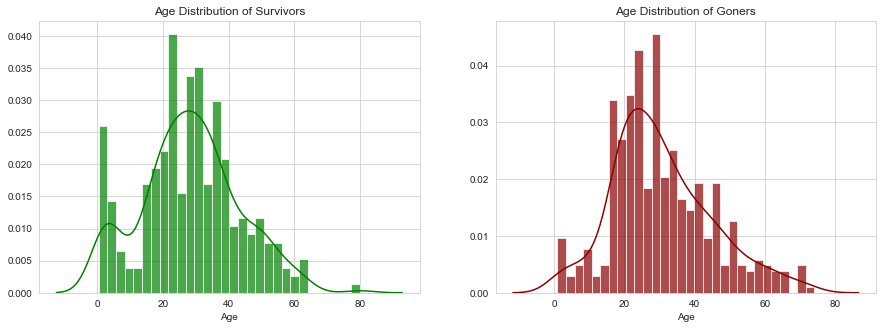

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax = sns.distplot(train[train['Survived']==1]['Age'].dropna(),hist_kws=dict(alpha=0.7),color = 'green',bins = 30)
plt.title("Age Distribution of Survivors")
ax.set(xlabel='Age')


plt.subplot(1,2,2)
ax = sns.distplot(train[train['Survived']==0]['Age'].dropna(),hist_kws=dict(alpha=0.7),color = 'darkred',bins = 30)
plt.title("Age Distribution of Goners")
ax.set(xlabel='Age')

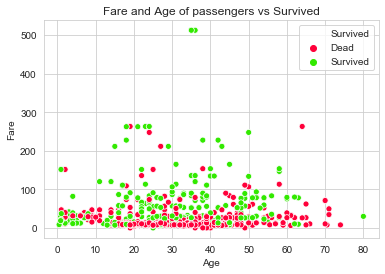

In [12]:
sns.scatterplot(y='Fare',x='Age',data=train,hue ='Survived',palette='prism_r')
plt.title("Fare and Age of passengers vs Survived")
L =plt.legend()
L.get_texts()[1].set_text('Dead')
L.get_texts()[2].set_text('Survived')
#Most passengers with lower fare died, with the exception of younger passengers

Text(0, 0.5, 'Count')

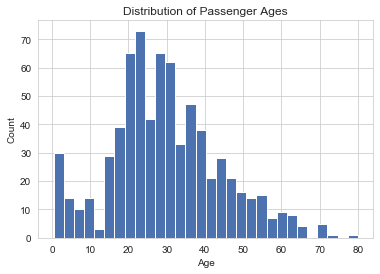

In [13]:
plt.hist(train['Age'].dropna(), bins=30)
plt.title("Distribution of Passenger Ages")
plt.xlabel("Age")
plt.ylabel("Count")

# Data Cleaning

# Extract Title

In [14]:
df['Title'] = title_extractor(df)


In [15]:
print("Missing values in 'Title': {}".format(df.isnull().sum()['Title']))

Missing values in 'Title': 1


In [16]:
# train has one missing value that the title_extractor did not properly take care of
missing_title_ind = df['Title'][lambda x: pd.isnull(x)].index
display(df.loc[missing_title_ind])



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
759,760,1.0,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S,NaN


In [17]:
# The regex in the function did not manage to capture "the Countess"
# Manually taking care of it
df.loc[df[df.Title.isnull()].index,'Title'] = 'Countess'


# Impute Age

In [18]:
# Impute age by mean of each 'Title'
df['Age'] = impute_category_mean(df,'Age','Title')


# Impute Fare

In [19]:
# Fill in missing Fares by Passenger Class
df['Fare'] = impute_category_mean(df, 'Fare', 'Pclass')

# Cabin?

In [20]:
cabin_first_letter = df['Cabin'].str[0]

In [21]:
pd.crosstab(df['Pclass'],cabin_first_letter.fillna('no data'))

Cabin,A,B,C,D,E,F,G,T,no data
Pclass,,,,,,,,,
1,22,65,94,40,34,0,0,1,67
2,0,0,0,6,4,13,0,0,254
3,0,0,0,0,3,8,5,0,693


#### Since a lot of the data is missing, it is difficult to assume which cabin will the passenger be in.
##### Only use Pclass as a predictor and discard Cabin

In [22]:
df.drop(['Cabin'], axis=1, inplace=True)

# Embarked

In [23]:
# Since only 2 entries are missing

df['Embarked'] = df['Embarked'].fillna('mode')

In [24]:
display_num_nulls(df)

,sum,avg
PassengerId,0,0.000000
Survived,418,0.319328
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


# Get Dummies

In [25]:
clf_df = pd.concat([df,pd.get_dummies(df[['Embarked','Title','Sex']], dummy_na=True, drop_first=True)], axis=1)
clf_df.drop(clf_df.select_dtypes('object').columns, axis=1, inplace=True)

# Dummied test
clf_df_t = clf_df[clf_df['Survived'].isnull()].drop('Survived', axis=1)

# Dummied train
clf_df_tr = clf_df[clf_df['Survived'].notnull()]

# Modeling: Testing model on 'train' data

In [26]:
X = clf_df_tr.drop('Survived', axis=1)
y = clf_df_tr['Survived']
Xtr, Xt, ytr, yt = train_test_split(X, y, test_size=0.3, random_state=123)


In [27]:

lg = LogisticRegression(solver='liblinear')
lg.fit(Xtr,ytr)
lgpred_tr = lg.predict(Xtr)
tr_score = accuracy_score(ytr, lgpred_tr)

lgpred_t = lg.predict(Xt)
t_score = accuracy_score(yt,lgpred_t)

print("Training Accuracy: {}\nTest Accuracy: {}".format("%.2f" % tr_score, "%.2f" % t_score))

Training Accuracy: 0.83
Test Accuracy: 0.83


In [28]:

rf = RandomForestClassifier(n_estimators=100, criterion='gini')
rf.fit(Xtr,ytr)
rfpred_tr = rf.predict(Xtr)
tr_score = accuracy_score(ytr, rfpred_tr)

rfpred_t = rf.predict(Xt)
t_score = accuracy_score(yt,rfpred_t)

print("Training Accuracy: {}\nTest Accuracy: {}".format("%.2f" % tr_score, "%.2f" % t_score))

Training Accuracy: 1.00
Test Accuracy: 0.82


In [29]:

svc = SVC(C=1, kernel= 'linear', gamma='auto')
svc.fit(Xtr, ytr)
svcpred_tr = svc.predict(Xtr)
svcpred_t = svc.predict(Xt)
accuracy_score(yt,svcpred_t)
print("Training Accuracy: {}\nTest Accuracy: {}".format("%.2f" % tr_score, "%.2f" % t_score))

Training Accuracy: 1.00
Test Accuracy: 0.82


# Modeling: Building Model using full 'train' data

In [30]:
lg = LogisticRegression(solver='liblinear')
lg.fit(X,y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
rf = RandomForestClassifier(n_estimators=100, criterion='gini')
rf.fit(X,y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
svc = SVC(kernel='linear', gamma='auto')
svc.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

# Modeling: Making Predictions

In [33]:
lgpred = lg.predict(clf_df_t)
rfpred = rf.predict(clf_df_t)
svcpred = svc.predict(clf_df_t)

In [34]:
pd.concat([test['PassengerId'], pd.DataFrame(lgpred.astype(int))],axis=1).rename(columns={0:'Survived'}).to_csv('lg.csv', index=False)
pd.concat([test['PassengerId'], pd.DataFrame(rfpred.astype(int))],axis=1).rename(columns={0:'Survived'}).to_csv('rf.csv', index=False)
pd.concat([test['PassengerId'], pd.DataFrame(svcpred.astype(int))],axis=1).rename(columns={0:'Survived'}).to_csv('svc.csv', index=False)

In [35]:
pd.DataFrame([test['PassengerId'],lgpred], ['PassengerId','Survived']).transpose()

,PassengerId,Survived
0,892.0,0.0
1,893.0,1.0
2,894.0,0.0
3,895.0,0.0
4,896.0,1.0
...,...,...
413,1305.0,0.0
414,1306.0,1.0
415,1307.0,0.0
416,1308.0,0.0


# ***Why are samples misclassified?

In [36]:
# Indices of correctly and wrongly classified samples
lg_correct_ind = Xt[yt==lgpred_t].index
lg_wrong_ind = Xt[yt!=lgpred_t].index

# Correctly classified and Wrongly classified samples
lg_correct = df.loc[lg_correct_ind]
lg_wrong = df.loc[lg_wrong_ind]


In [37]:
# Indices of correctly and wrongly classified samples
rf_correct_ind = Xt[yt==rfpred_t].index
rf_wrong_ind = Xt[yt!=rfpred_t].index

# Correctly classified and Wrongly classified samples
rf_correct = df.loc[rf_correct_ind]
rf_wrong = df.loc[rf_wrong_ind]


In [38]:
# Combination of rf and lg
wrong_ind = np.intersect1d(lg_wrong_ind, rf_wrong_ind)
wrong = df.loc[wrong_ind]

In [39]:
# Combination of rf and lg

correct_ind = np.intersect1d(lg_correct_ind,rf_correct_ind)
correct = df.loc[correct_ind]

Text(0.5, 1.0, 'Age, Misclassified Samples')

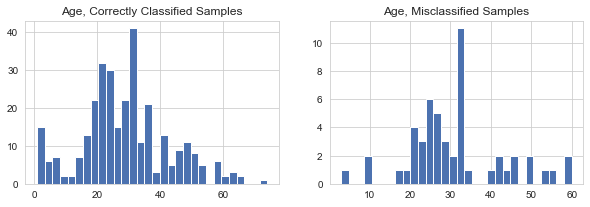

In [40]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].hist(correct['Age'], bins=30)
ax[1].hist(wrong['Age'], bins=30)

ax[0].set_title('Age, Correctly Classified Samples')
ax[1].set_title('Age, Misclassified Samples')

Text(0.5, 1.0, 'SibSp, Misclassified Samples')

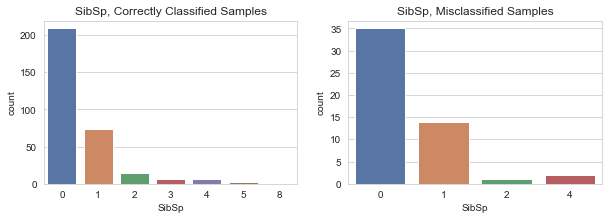

In [41]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

sns.countplot(correct['SibSp'],ax=ax[0])

sns.countplot(wrong['SibSp'],ax=ax[1])

ax[0].set_title('SibSp, Correctly Classified Samples')
ax[1].set_title('SibSp, Misclassified Samples')

Text(0.5, 1.0, 'Title, Misclassified Samples')

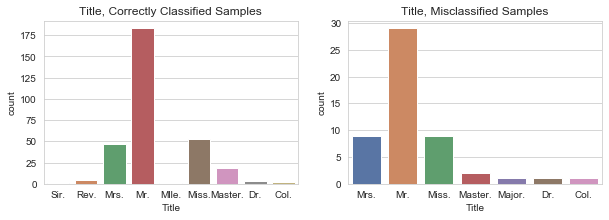

In [42]:
fig, ax = plt.subplots(1,2, figsize=(10,3))

sns.countplot(correct['Title'].sort_values(ascending=False),ax=ax[0],)
sns.countplot(wrong['Title'].sort_values(ascending=False),ax=ax[1])


ax[0].set_title('Title, Correctly Classified Samples')
ax[1].set_title('Title, Misclassified Samples')

(array([33.,  8.,  7.,  1.,  0.,  0.,  1.,  1.,  0.,  1.]),
 array([  6.975 ,  27.4275,  47.88  ,  68.3325,  88.785 , 109.2375,
        129.69  , 150.1425, 170.595 , 191.0475, 211.5   ]),
 <a list of 10 Patch objects>)

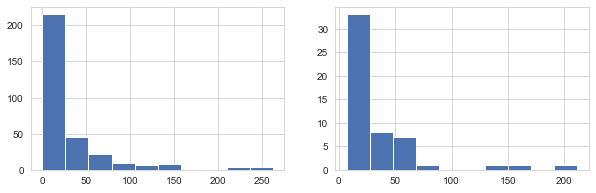

In [43]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].hist(correct['Fare'])
ax[1].hist(wrong['Fare'])

Text(0.5, 1, 'Confusion Matrix: Logistic Regression')

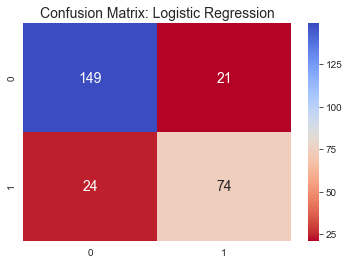

In [44]:
sns.set_context(font_scale=4)
sns.heatmap(confusion_matrix(yt, lgpred_t), annot=True, fmt= '.0f', cmap='coolwarm_r', annot_kws={'size':14})
plt.title('Confusion Matrix: Logistic Regression', fontsize=14)

Text(0.5, 1, 'Confusion Matrix: Random Forest')

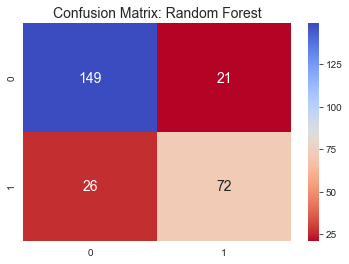

In [45]:
sns.set_context(font_scale=4)
sns.heatmap(confusion_matrix(yt, rfpred_t), annot=True, fmt= '.0f', cmap='coolwarm_r', annot_kws={'size':14})
plt.title('Confusion Matrix: Random Forest', fontsize=14)